In [7]:
import tensorflow as tf 
import numpy as np
import cv2
import time
from tqdm import tqdm

In [8]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images = np.pad(train_images,[[0,0],[2,2],[2,2]],"constant",constant_values=0)
train_images = np.expand_dims(train_images,-1)
train_images = train_images.astype(np.float32) / 255.0
# print(train_images.dtype)

test_images = np.pad(test_images,[[0,0],[2,2],[2,2]],"constant",constant_values=0)
test_images = np.expand_dims(test_images,-1)
test_images = test_images.astype(np.float32) / 255.0
# print(train_images.dtype)

各模型準確度評估

In [9]:

def call(interpreter_path,img):
    #加载模型并分配张量
    interpreter = tf.lite.Interpreter(model_path=interpreter_path)
    interpreter.allocate_tensors()

    #获得输入输出张量.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    # print(output_details)
    index = input_details[0]['index']
    shape = input_details[0]['shape']
    # print("當前輸入圖片格式: ",img.shape)
    # print("當前輸入圖片所需格式: ",shape)
    interpreter.set_tensor(index, img.reshape(shape).astype("float32"))
    interpreter.invoke()
    if output_details[0]['shape'].shape==(2,) and output_details[0]['shape'][1]==10:
        predict = interpreter.get_tensor(output_details[0]['index'])
        try:
            params = interpreter.get_tensor(output_details[1]['index'])
            return predict,params
        except IndexError:
            return predict,0
    else:
        predict = interpreter.get_tensor(output_details[1]['index'])
        params = interpreter.get_tensor(output_details[0]['index'])
        return predict,params

def model_call(folder_address,img):
    start_time=np.zeros(7)
    end_time=np.zeros(7)
    for i in range(1,7):
        # print(f"第{i}層")
        if i == 1:
            start_time[i] = time.perf_counter()
            predict, params = call(f"{folder_address}/Exit_Model_{i}.tflite", img)
            end_time[i] = time.perf_counter()
            
        else:
            start_time[i] = time.perf_counter()
            predict, params = call(f"{folder_address}/Exit_Model_{i}.tflite", params)
            end_time[i] = time.perf_counter()
            
        max_softmax = np.max(predict,-1)
        predict_num = np.argmax(predict,-1)
        # print(f"最大softmax: {max_softmax},  此層運算時間: {(end_time[i]-start_time[i])*1000}ms")
        # print(f"預測數字: {predict_num}")
        if(max_softmax>=0.9):
            break      
    # print(f"總運算時間: {(end_time.sum()-start_time.sum())*1000}ms")
    return predict_num

def evaluate(folder_address,images,labels):
    accuracy_count = 0
    image_count = images.shape[0]
    for i in tqdm(range(image_count)):
        predict_num = model_call(folder_address,images[i])
        if predict_num == labels[i]:
            accuracy_count += 1
    return accuracy_count/image_count

In [10]:

initial_accuracy = evaluate("./TFLITE_Models/Initial_Models",test_images,test_labels)
dynamic_accuracy = evaluate("./TFLITE_Models/Dynamic_Models",test_images,test_labels)
float16_accuracy = evaluate("./TFLITE_Models/Float16_Models",test_images,test_labels)
partial_uint8_accuracy = evaluate("./TFLITE_Models/Partial_Uint8_Models",test_images,test_labels)

100%|██████████| 10000/10000 [00:26<00:00, 381.04it/s]


全整數模型準確度評估

In [11]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images = np.pad(train_images,[[0,0],[2,2],[2,2]],"constant",constant_values=0)
train_images = np.expand_dims(train_images,-1)
# train_images = train_images.astype(np.float32) / 255.0
# print(train_images.dtype)

test_images = np.pad(test_images,[[0,0],[2,2],[2,2]],"constant",constant_values=0)
test_images = np.expand_dims(test_images,-1)
# test_images = test_images.astype(np.float32) / 255.0

def call(interpreter_path,img):
    #加载模型并分配张量
    interpreter = tf.lite.Interpreter(model_path=interpreter_path)
    interpreter.allocate_tensors()

    #获得输入输出张量.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    # print(output_details)
    index = input_details[0]['index']
    shape = input_details[0]['shape']
    # print("當前輸入圖片格式: ",img.shape)
    # print("當前輸入圖片所需格式: ",shape)
    interpreter.set_tensor(index, img.reshape(shape).astype("uint8"))
    interpreter.invoke()
    if output_details[0]['shape'].shape==(2,) and output_details[0]['shape'][1]==10:
        predict = interpreter.get_tensor(output_details[0]['index'])
        try:
            params = interpreter.get_tensor(output_details[1]['index'])
            return predict,params
        except IndexError:
            return predict,0
    else:
        predict = interpreter.get_tensor(output_details[1]['index'])
        params = interpreter.get_tensor(output_details[0]['index'])
        return predict,params

def model_call(folder_address,img):
    start_time=np.zeros(7)
    end_time=np.zeros(7)
    for i in range(1,7):
        # print(f"第{i}層")
        if i == 1:
            start_time[i] = time.perf_counter()
            predict, params = call(f"{folder_address}/Exit_Model_{i}.tflite", img)
            end_time[i] = time.perf_counter()
            
        else:
            start_time[i] = time.perf_counter()
            predict, params = call(f"{folder_address}/Exit_Model_{i}.tflite", params)
            end_time[i] = time.perf_counter()
            
        max_softmax = np.max(predict,-1)
        predict_num = np.argmax(predict,-1)
        # print(f"最大softmax: {max_softmax},  此層運算時間: {(end_time[i]-start_time[i])*1000}ms")
        # print(f"預測數字: {predict_num}")
        if(max_softmax>=0.9):
            break      
    # print(f"總運算時間: {(end_time.sum()-start_time.sum())*1000}ms")
    return predict_num

def evaluate(folder_address,images,labels):
    accuracy_count = 0
    image_count = images.shape[0]
    for i in tqdm(range(image_count)):
        predict_num = model_call(folder_address,images[i])
        if predict_num == labels[i]:
            accuracy_count += 1
    return accuracy_count/image_count
full_uint8_accuracy = evaluate("./TFLITE_Models/Full_Uint8_Models",test_images,test_labels)

100%|██████████| 10000/10000 [00:14<00:00, 680.49it/s]


In [12]:
print(f"TFLITE_INITIAL_ACCURACY: {initial_accuracy*100}%")
print(f"TFLITE_DYNAMIC_ACCURACY: {dynamic_accuracy*100}%")
print(f"TFLITE_FLOAT16_ACCURACY: {float16_accuracy*100}%")
print(f"TFLITE_PARTIAL_UINT8_ACCURACY: {partial_uint8_accuracy*100}%")
print(f"TFLITE_FULL_UINT8_ACCURACY: {full_uint8_accuracy*100}%")

TFLITE_INITIAL_ACCURACY: 97.86%
TFLITE_DYNAMIC_ACCURACY: 97.89%
TFLITE_FLOAT16_ACCURACY: 97.88%
TFLITE_PARTIAL_UINT8_ACCURACY: 97.88%
TFLITE_FULL_UINT8_ACCURACY: 88.97%


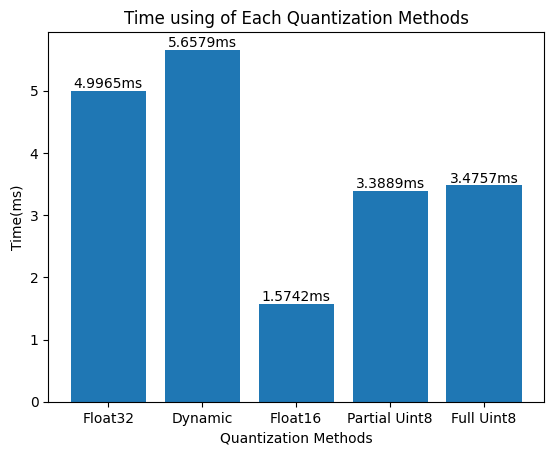

In [29]:
import matplotlib.pyplot as plt
x=[1,2,3,4,5]
y=[4.9965,5.6579,1.5742,3.3889,3.4757]
plt.bar(x,y,tick_label=["Float32","Float16","Full Uint8","Partial Uint8","Dynamic"])
plt.xlabel("Quantization Methods")
plt.ylabel("Time(ms)")  
plt.title("Time using of Each Quantization Methods")
for i in range(len(x)):
    plt.text(x[i],y[i],f"{y[i]}ms",ha="center",va="bottom")
plt.show()
